Imports and Setup

In [1]:
!pip install medmnist matplotlib scikit-learn

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split, ConcatDataset
from torchvision import models, transforms
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc, confusion_matrix,
    classification_report, precision_score, recall_score, f1_score,
    roc_auc_score, accuracy_score
)

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from tqdm import tqdm

import medmnist
from medmnist import INFO

/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Deliverable 1 - Training of new model based on ResNet-18 to increase AUC and Accuracy

In [3]:

#Data augmentation

from torchvision.transforms import v2

data_augmentation_transform = v2.Compose([
    #v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomRotation(degrees=10),
    v2.RandomAffine(degrees=0,translate=(0.1,0.1)),
    v2.RandomHorizontalFlip(p=0.5),
    #v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor(),
    v2.Normalize(mean=[0.5], std=[0.5])
])

/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [17]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu is being used"

device = get_device()
print(device)

# Load and preprocess data
data_flag = 'breastmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Set seeds for reproducibility
torch.manual_seed(40)
np.random.seed(40)

# Load datasets
train_dataset = DataClass(split='train', transform=data_transform, download=True)
train_dataset_augmented = DataClass(split='train', transform=data_augmentation_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)

cuda
Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz


In [138]:
# Set hyperparameters
PATH = "/home/sevi/AI_Yildiz/resnet18.pth"
BATCH_SIZE = 16 #72
NUM_EPOCHS = 18 #40
LR = 0.0009
DROPOUT_RATE = 0.3
MOMENTUM = 0.95
WEIGHT_DECAY = 0.00008

In [139]:
# Define a modified ResNet-18 model with dropout
class ModifiedResNet18(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ModifiedResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=1, padding=1, bias=False) # kernel_size=7, stride=2, padding=3, bias=False)
        # Add dropout layer
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        return x


In [140]:
# Initialize the model, optimizer, and loss function
model = ModifiedResNet18(n_channels, n_classes)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = optim.Adam(model.parameters(), lr=0.0009, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00001, amsgrad=True)
criterion = nn.CrossEntropyLoss()


/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Loading the model
model = torch.load(PATH)

In [141]:
'''def train(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs} complete. Loss: {running_loss / len(train_loader)}")'''

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    training_losses = []
    validation_losses = []
    model = model.to(device)
    model.train()
    for epoch in range(num_epochs):
        epoch_training_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            loss.backward()
            optimizer.step()
            epoch_training_loss += loss.item()
        
        training_losses.append(epoch_training_loss / len(train_loader))
        
        # Validation phase
        epoch_validation_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets.squeeze().long())
                epoch_validation_loss += loss.item()
        validation_losses.append(epoch_validation_loss / len(val_loader))
        print(f"Epoch {epoch + 1}/{num_epochs} complete. Loss: {epoch_training_loss / len(train_loader)} \t\t Validation Loss: {epoch_validation_loss / len(val_loader)}")
        #print(f'Epoch {epoch+1}, Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}')
    
    return training_losses, validation_losses

In [142]:
def evaluate(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(targets.squeeze().tolist())
            y_pred.extend(predictions.tolist())
            y_scores.extend(outputs[:, 1].cpu().detach().numpy())

    auc_score = roc_auc_score(y_true, y_scores)
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Evaluation results -- AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")

    return auc_score, accuracy

In [9]:
#tune hyperparams
# Hyperparameter grid
'''learning_rates = [0.001, 0.0001]
batch_sizes = [32, 64]
momentums = [0.9, 0.95]
epochs_list = [10, 20, 30]
dropout_rates = [0.3, 0.5]
weight_decays = [0.00005, 0.0001]'''

#Best Validation AUC: 0.8860
#Best Validation Accuracy: 0.8846
#Best hyperparameters: {'learning_rate': 0.001, 'batch_size': 64, 'momentum': 0.9, 'epochs': 30, 'dropout_rate': 0.5, 'weight_decay': 0.00005}

'''learning_rates = [0.0009, 0.001, 0.0011]
batch_sizes = [64, 80]
momentums = [0.94, 0.95]
epochs_list = [30, 40] 
dropout_rates = [0.3, 0.35] 
weight_decays = [0.0001, 0.00012]'''
#Best Validation AUC: 0.8966
#Best Validation Accuracy: 0.8910
#Best hyperparameters: {'learning_rate': 0.0009, 'batch_size': 64, 'momentum': 0.94, 'epochs': 40, 'dropout_rate': 0.3, 'weight_decay': 0.0001} on test dataset

'''learning_rates = [0.00085, 0.0009, 0.00095]
batch_sizes = [60, 64, 68]
momentums = [0.93, 0.94, 0.95]
epochs_list = [35, 40, 45]
dropout_rates = [0.28, 0.3, 0.32]
weight_decays = [0.0001, 0.00011, 0.00013]'''
#Best Validation AUC: 0.9325
#Best Validation Accuracy: 0.9103
#Best hyperparameters: {'learning_rate': 0.0009, 'batch_size': 60, 'momentum': 0.95, 'epochs': 45, 'dropout_rate': 0.3, 'weight_decay': 0.0001}
'''
learning_rates = [0.0009]
batch_sizes = [60, 64, 68, 72]#, 76, 80]
momentums = [0.95]
epochs_list = [30, 35, 40, 45, 50]
dropout_rates = [0.3]
weight_decays = [0.0001]

# Best performance placeholders
best_auc = 0
best_accuracy = 0
best_params = {}'''
# Grid search over hyperparameters
'''for lr in learning_rates:
    for batch in batch_sizes:
        for momentum in momentums:
            for num_epochs in epochs_list:
                for dropout in dropout_rates:
                    for weight_decay in weight_decays:
                        print(f"Testing LR={lr}, Batch={batch}, Momentum={momentum}, Epochs={num_epochs}, Dropout={dropout}, Weight Decay={weight_decay}")
                        model = ModifiedResNet18(n_channels, n_classes)
                        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
                        criterion = nn.CrossEntropyLoss()
                        
                        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
                        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
                        test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

                        train(model, train_loader, val_loader, optimizer, criterion, num_epochs)
                        #val_auc, val_accuracy = evaluate(model, test_loader)
                        val_auc, val_accuracy = evaluate(model, val_loader)
                                                
                        
                        #if val_auc > best_auc or val_accuracy > best_accuracy:
                        if val_auc > best_auc:
                            best_auc = val_auc
                            best_params['learning_rate'] = lr
                            best_params['batch_size'] = batch
                            best_params['momentum'] = momentum
                            best_params['epochs'] = num_epochs
                            best_params['dropout_rate'] = dropout
                            best_params['weight_decay'] = weight_decay
                            print(f"New best AUC: {best_auc:.4f} with params: {best_params}")
                        if val_accuracy > best_accuracy:
                            best_accuracy = val_accuracy
                            best_params['learning_rate'] = lr
                            best_params['batch_size'] = batch
                            best_params['momentum'] = momentum
                            best_params['epochs'] = num_epochs
                            best_params['dropout_rate'] = dropout
                            best_params['weight_decay'] = weight_decay
                            print(f"New best Accuracy: {best_accuracy:.4f} with params: {best_params}")
                        #print(f"New best AUC: {best_auc:.4f} and Accuracy: {best_accuracy:.4f} with params: {best_params}")'''

'''
for batch in batch_sizes:
    for num_epochs in epochs_list:
        print(f"Testing Batch={batch}, Epochs={num_epochs}")
        model = ModifiedResNet18(n_channels, n_classes)
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        criterion = nn.CrossEntropyLoss()
        
        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

        train(model, train_loader, val_loader, optimizer, criterion, num_epochs)
        #val_auc, val_accuracy = evaluate(model, test_loader)
        val_auc, val_accuracy = evaluate(model, val_loader)
                                
        
        #if val_auc > best_auc or val_accuracy > best_accuracy:
        if val_auc > best_auc:
            best_auc = val_auc
            best_params['batch_size'] = batch
            best_params['epochs'] = num_epochs
            print(f"New best AUC: {best_auc:.4f} with params: {best_params}")
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params['batch_size'] = batch
            best_params['epochs'] = num_epochs
            print(f"New best Accuracy: {best_accuracy:.4f} with params: {best_params}")


# Display the best hyperparameters
print(f"Best Validation AUC: {best_auc:.4f}")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best hyperparameters: {best_params}")'''

'\nfor batch in batch_sizes:\n    for num_epochs in epochs_list:\n        print(f"Testing Batch={batch}, Epochs={num_epochs}")\n        model = ModifiedResNet18(n_channels, n_classes)\n        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\n        criterion = nn.CrossEntropyLoss()\n        \n        train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)\n        val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)\n        test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)\n\n        train(model, train_loader, val_loader, optimizer, criterion, num_epochs)\n        #val_auc, val_accuracy = evaluate(model, test_loader)\n        val_auc, val_accuracy = evaluate(model, val_loader)\n                                \n        \n        #if val_auc > best_auc or val_accuracy > best_accuracy:\n        if val_auc > best_auc:\n            best_auc = val_auc\n            best_params[\'batch_siz

In [147]:
# Prepare data loaders
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(ConcatDataset([train_dataset, train_dataset_augmented]), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Training the model
training_losses, validation_losses = train(model, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS)




Epoch 1/18 complete. Loss: 0.3557737261812756 		 Validation Loss: 0.5794602274894715
Epoch 2/18 complete. Loss: 0.230040045009683 		 Validation Loss: 0.2716888502240181
Epoch 3/18 complete. Loss: 0.19007936778707782 		 Validation Loss: 0.33416188061237334
Epoch 4/18 complete. Loss: 0.20849305264435816 		 Validation Loss: 0.3562041655182838
Epoch 5/18 complete. Loss: 0.18315818676374096 		 Validation Loss: 0.44806690216064454
Epoch 6/18 complete. Loss: 0.15156577511326128 		 Validation Loss: 0.5578523874282837
Epoch 7/18 complete. Loss: 0.16569791282054738 		 Validation Loss: 0.536095866560936
Epoch 8/18 complete. Loss: 0.22439200294109574 		 Validation Loss: 0.5907273262739181
Epoch 9/18 complete. Loss: 0.11010640418912837 		 Validation Loss: 0.5705352693796157
Epoch 10/18 complete. Loss: 0.1147271335138467 		 Validation Loss: 0.5793505311012268
Epoch 11/18 complete. Loss: 0.11056751361035783 		 Validation Loss: 0.574728924036026
Epoch 12/18 complete. Loss: 0.12293925346212758 		 Valid

Evaluating on validation dataset:
Evaluation results -- AUC: 0.8972, Accuracy: 0.8974
Evaluating on separate test dataset:
Evaluation results -- AUC: 0.8709, Accuracy: 0.8526


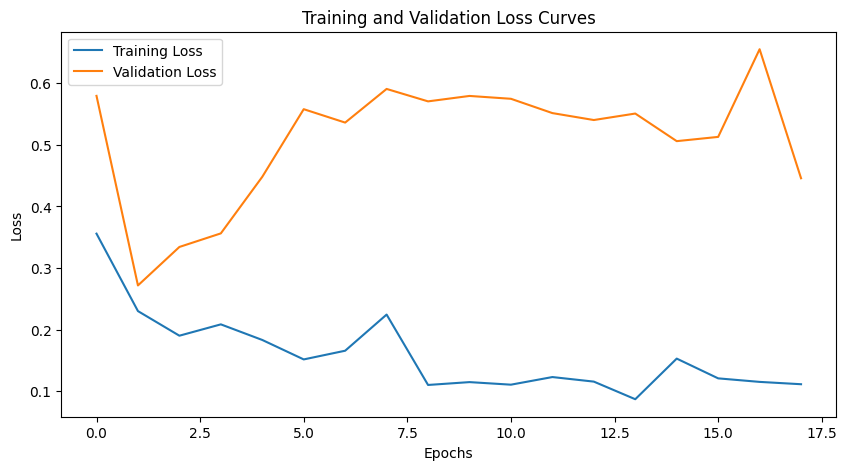

In [148]:
model = torch.load(PATH)

# Evaluating on validation dataset
print("Evaluating on validation dataset:")
val_auc, val_accuracy = evaluate(model, val_loader)

# Evaluating on test dataset
print("Evaluating on separate test dataset:")
test_auc, test_accuracy = evaluate(model, test_loader)


plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

Deliverable 2 - Displaying the AUPR, Precision, Recall and F1 Score

In [11]:
## updating the evaluate function to dispkay extras

In [12]:
# Load and preprocess data again so that the results dont get skewed if all teh code is run togetehr
data_flag = 'breastmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Set seeds for reproducibility
torch.manual_seed(40)
np.random.seed(40)

# Load datasets
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)


# Initialize the model, optimizer, and loss function
model = ModifiedResNet18(n_channels, n_classes)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

Using downloaded and verified file: C:\Users\606\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\606\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\606\.medmnist\breastmnist.npz


C:\Users\606\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\606\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [149]:
def evaluate(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(targets.squeeze().tolist())
            y_pred.extend(predictions.tolist())
            y_scores.extend(outputs[:, 1].cpu().detach().numpy())

    # Calculate metrics
    auc_score = roc_auc_score(y_true, y_scores)
    accuracy = accuracy_score(y_true, y_pred)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    aupr_score = auc(recall_vals, precision_vals) # Calculate AUPR using the auc function
    precision_val = precision_score(y_true, y_pred, average='binary')
    recall_val = recall_score(y_true, y_pred, average='binary')
    f1_val = f1_score(y_true, y_pred, average='binary')

    # Print evaluation results
    print(f"Evaluation results -- AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")
    print(f"AUPR: {aupr_score:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")
    
    # Return metrics 
    return auc_score, aupr_score, accuracy, precision_val, recall_val, f1_val


In [154]:
# Prepare data loaders again for the new evaluate function
train_loader = DataLoader(ConcatDataset([train_dataset, train_dataset_augmented]), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training the model
#train(model, train_loader, optimizer, criterion, NUM_EPOCHS)
train(model, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS)


Epoch 1/18 complete. Loss: 0.35906247762697086 		 Validation Loss: 0.6112422659993172
Epoch 2/18 complete. Loss: 0.13003946197485286 		 Validation Loss: 0.5778633117675781
Epoch 3/18 complete. Loss: 0.27789190682981696 		 Validation Loss: 0.42455175518989563
Epoch 4/18 complete. Loss: 0.2042290024326316 		 Validation Loss: 0.5075800120830536
Epoch 5/18 complete. Loss: 0.1378246779420546 		 Validation Loss: 0.4757048189640045
Epoch 6/18 complete. Loss: 0.12412634223167385 		 Validation Loss: 0.4929692387580872
Epoch 7/18 complete. Loss: 0.11898890497562076 		 Validation Loss: 0.6184714794158935
Epoch 8/18 complete. Loss: 0.15906280130147935 		 Validation Loss: 0.4772960841655731
Epoch 9/18 complete. Loss: 0.12294454790784844 		 Validation Loss: 0.4909180343151093
Epoch 10/18 complete. Loss: 0.10443879568151065 		 Validation Loss: 0.5761596858501434
Epoch 11/18 complete. Loss: 0.15877053600602917 		 Validation Loss: 0.5335306525230408
Epoch 12/18 complete. Loss: 0.3043101415304201 		 Val

([0.35906247762697086,
  0.13003946197485286,
  0.27789190682981696,
  0.2042290024326316,
  0.1378246779420546,
  0.12412634223167385,
  0.11898890497562076,
  0.15906280130147935,
  0.12294454790784844,
  0.10443879568151065,
  0.15877053600602917,
  0.3043101415304201,
  0.2490538949412959,
  0.2308009202991213,
  0.1628826204338111,
  0.15819041533395647,
  0.11849827202303069,
  0.08969023531036717],
 [0.6112422659993172,
  0.5778633117675781,
  0.42455175518989563,
  0.5075800120830536,
  0.4757048189640045,
  0.4929692387580872,
  0.6184714794158935,
  0.4772960841655731,
  0.4909180343151093,
  0.5761596858501434,
  0.5335306525230408,
  0.328626249730587,
  0.4297258913516998,
  0.42384785413742065,
  0.4589230090379715,
  0.5078235417604446,
  0.6124690890312194,
  0.6591433823108673])

In [155]:
#model = torch.load(PATH)
print("Evaluating on validation dataset:")
val_metrics = evaluate(model, val_loader)
#val_auc, val_accuracy = evaluate(model, val_loader)

# Evaluating on test dataset
print("Evaluating on separate test dataset:")
test_metrics = evaluate(model, test_loader)
#test_auc, test_accuracy = evaluate(model, test_loader)

Evaluating on validation dataset:
Evaluation results -- AUC: 0.8947, Accuracy: 0.9103
AUPR: 0.9245, Precision: 0.9310, Recall: 0.9474, F1 Score: 0.9391
Evaluating on separate test dataset:
Evaluation results -- AUC: 0.8774, Accuracy: 0.9038
AUPR: 0.9348, Precision: 0.9381, Recall: 0.9298, F1 Score: 0.9339


Deliverable 3 - Plotting ROC Curve, PR Curve and Confusion Matrix

In [15]:
##changing the evaluate function so it plots the graphs as well

In [129]:
# Load and preprocess data again so that the results dont get skewed if all teh code is run togetehr
data_flag = 'breastmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Set seeds for reproducibility
torch.manual_seed(40)
np.random.seed(40)

# Load datasets
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)

# Initialize the model, optimizer, and loss function
model = ModifiedResNet18(n_channels, n_classes)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz


/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [130]:
def plot_evaluation_graphs(y_true, y_scores, y_pred):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    aupr_score = auc(recall_vals, precision_vals)    
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic')
    axes[0].legend(loc="lower right")

    # Precision-Recall Curve
    axes[1].plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (area = {aupr_score:.2f})')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curve')
    axes[1].legend(loc="lower right")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    im = axes[2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[2].figure.colorbar(im, ax=axes[2])
    axes[2].set_xlabel('Predicted labels')
    axes[2].set_ylabel('True labels')
    axes[2].set_title('Confusion Matrix')
    axes[2].set_xticks(np.arange(len(np.unique(y_true))))
    axes[2].set_yticks(np.arange(len(np.unique(y_true))))
    axes[2].xaxis.set_ticklabels(['Negative', 'Positive'], rotation=45)
    axes[2].yaxis.set_ticklabels(['Negative', 'Positive'])

    plt.tight_layout()
    plt.show()

def evaluate(model, data_loader):
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(targets.squeeze().tolist())
            y_pred.extend(predictions.tolist())
            y_scores.extend(outputs[:, 1].cpu().detach().numpy())

    auc_score = roc_auc_score(y_true, y_scores)
    accuracy = accuracy_score(y_true, y_pred)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    aupr_score = auc(recall_vals, precision_vals) # Calculate AUPR using the auc function
    precision_val = precision_score(y_true, y_pred, average='binary')
    recall_val = recall_score(y_true, y_pred, average='binary')
    f1_val = f1_score(y_true, y_pred, average='binary')

    # Print evaluation results
    print(f"Evaluation results -- AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")
    print(f"AUPR: {aupr_score:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")
    
     # Call to plot graphs
    plot_evaluation_graphs(y_true, y_scores, y_pred) 

    # Return metrics for further analysis
    return auc_score, aupr_score, accuracy, precision_val, recall_val, f1_val


In [134]:
# Prepare data loaders
train_loader = DataLoader(ConcatDataset([train_dataset, train_dataset_augmented]), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training the model
#train(model, train_loader, optimizer, criterion, NUM_EPOCHS)
train(model, train_loader, val_loader, optimizer, criterion, NUM_EPOCHS)

Epoch 1/18 complete. Loss: 1.6605653366872242 		 Validation Loss: 1.2617145895957946
Epoch 2/18 complete. Loss: 1.3655394897530122 		 Validation Loss: 1.2617145895957946
Epoch 3/18 complete. Loss: 1.3655285268489803 		 Validation Loss: 1.2617145895957946
Epoch 4/18 complete. Loss: 1.3654819008553334 		 Validation Loss: 1.2617145895957946
Epoch 5/18 complete. Loss: 1.365481883839571 		 Validation Loss: 1.2617145895957946
Epoch 6/18 complete. Loss: 1.3655299855662244 		 Validation Loss: 1.2617145895957946
Epoch 7/18 complete. Loss: 1.365561629286302 		 Validation Loss: 1.2617145895957946
Epoch 8/18 complete. Loss: 1.3654787851207273 		 Validation Loss: 1.2617145895957946
Epoch 9/18 complete. Loss: 1.3900916823319027 		 Validation Loss: 1.2617145895957946
Epoch 10/18 complete. Loss: 1.3656505506352654 		 Validation Loss: 1.2617145895957946
Epoch 11/18 complete. Loss: 1.4826514099325452 		 Validation Loss: 1.2617145895957946
Epoch 12/18 complete. Loss: 1.365523427674946 		 Validation Loss:

([1.6605653366872242,
  1.3655394897530122,
  1.3655285268489803,
  1.3654819008553334,
  1.365481883839571,
  1.3655299855662244,
  1.365561629286302,
  1.3654787851207273,
  1.3900916823319027,
  1.3656505506352654,
  1.4826514099325452,
  1.365523427674946,
  1.4023751054491316,
  1.4110744299633162,
  1.3654786840742288,
  1.3655259849636683,
  1.483381882735661,
  1.3655067125235552],
 [1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946,
  1.2617145895957946])

Evaluating on validation dataset:
Evaluation results -- AUC: 0.9131, Accuracy: 0.9487
AUPR: 0.9466, Precision: 0.9344, Recall: 1.0000, F1 Score: 0.9661


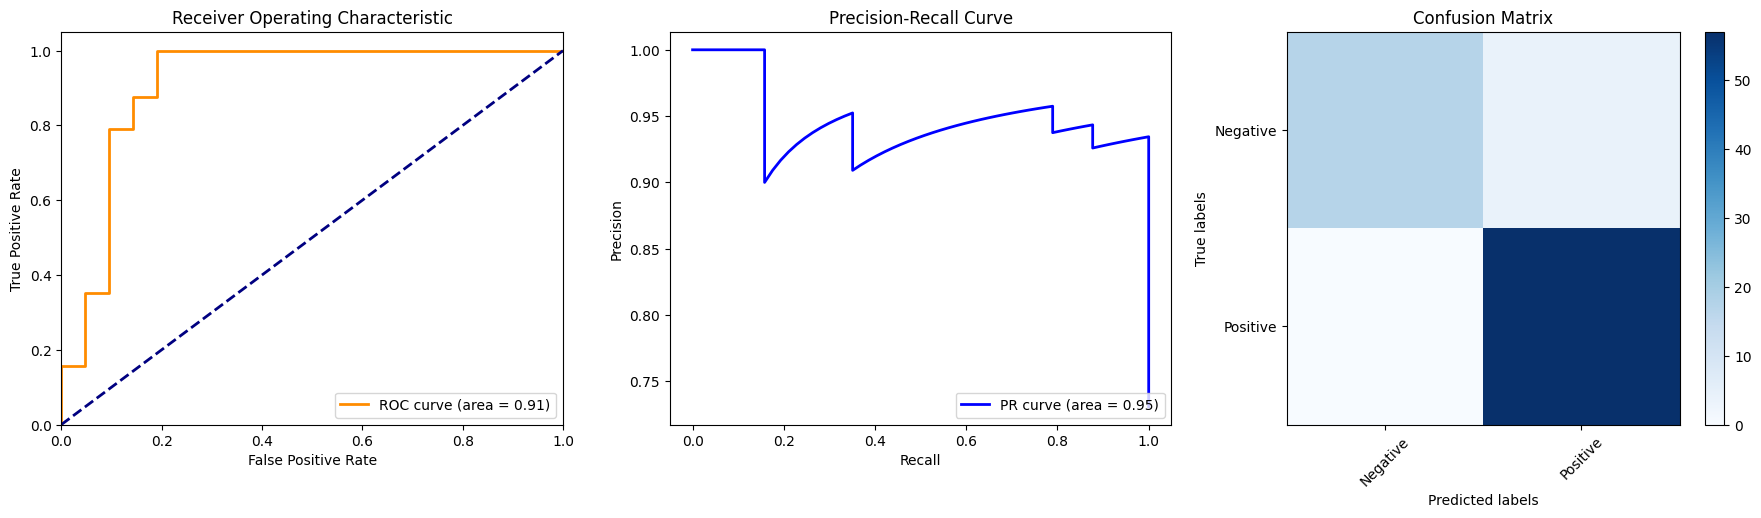

Evaluating on separate test dataset:
Evaluation results -- AUC: 0.9081, Accuracy: 0.8846
AUPR: 0.9489, Precision: 0.8934, Recall: 0.9561, F1 Score: 0.9237


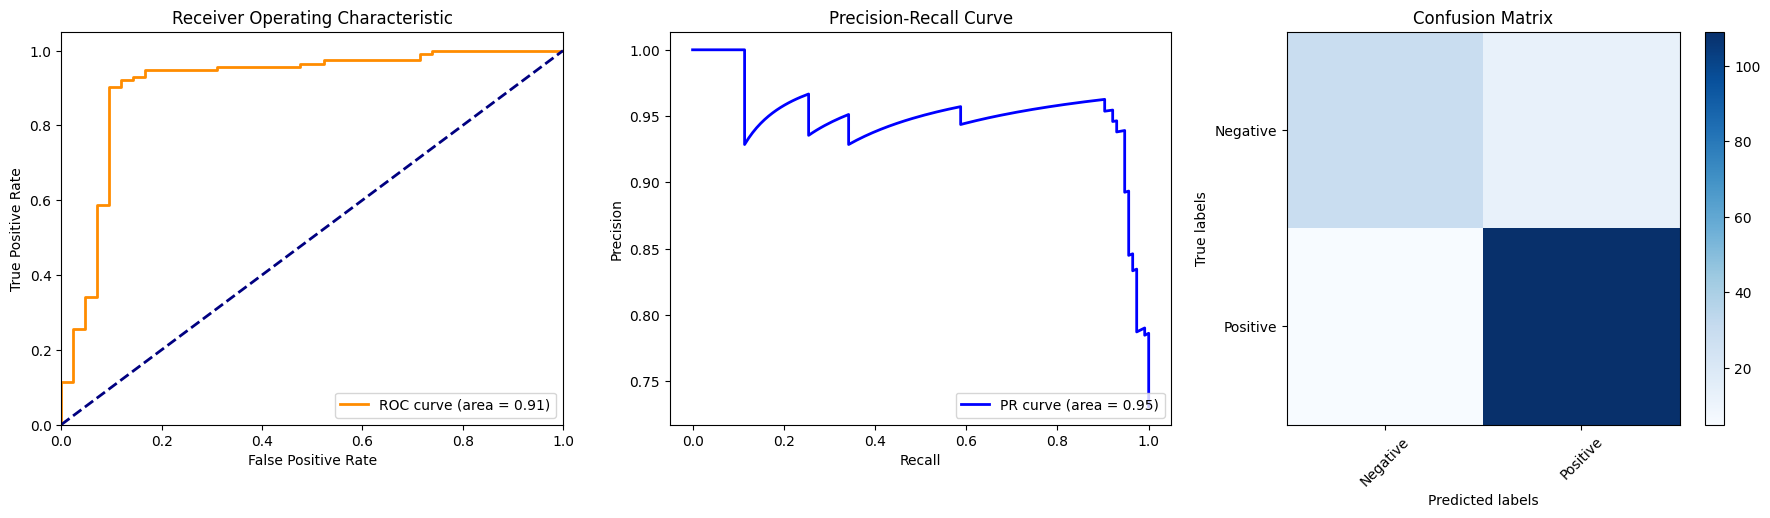

In [133]:
model = torch.load(PATH)
# Evaluating on validation dataset
print("Evaluating on validation dataset:")
val_metrics = evaluate(model, val_loader)

# Evaluating on test dataset-
print("Evaluating on separate test dataset:")
test_metrics = evaluate(model, test_loader)

Deliverable 4 - Implementing 5-fold Cross Validation

In [19]:
#adding 5 fold cross validation

In [20]:
# Load and preprocess data again so that the results dont get skewed if all teh code is run togetehr
data_flag = 'breastmnist'
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Set seeds for reproducibility
torch.manual_seed(40)
np.random.seed(40)

# Load datasets and combine them
train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
full_dataset = ConcatDataset([train_dataset,train_dataset_augmented, test_dataset, val_dataset])  # Merging datasets for cross-validation

# Initialize the model, optimizer, and loss function
model = ModifiedResNet18(n_channels, n_classes)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()

Using downloaded and verified file: C:\Users\606\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\606\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\606\.medmnist\breastmnist.npz


C:\Users\606\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\606\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:
#using a trainign model that doesnt have a validation phase since that happens as part of the 5fold
def train(model, train_loader, optimizer, criterion, num_epochs):
    model = model.to(device)
    model.train()
    for epoch in range(num_epochs):
        #for inputs, targets in tqdm(train_loader):
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{num_epochs} complete.")

def evaluate(model, data_loader):
    model = model.to(device)
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(targets.squeeze().tolist())
            y_pred.extend(predictions.tolist())
            y_scores.extend(outputs[:, 1].cpu().detach().numpy())

    auc_score = roc_auc_score(y_true, y_scores)
    accuracy = accuracy_score(y_true, y_pred)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    aupr_score = auc(recall_vals, precision_vals) # Calculate AUPR using the auc function
    precision_val = precision_score(y_true, y_pred, average='binary')
    recall_val = recall_score(y_true, y_pred, average='binary')
    f1_val = f1_score(y_true, y_pred, average='binary')

    # Return metrics
    return auc_score, aupr_score, accuracy, precision_val, recall_val, f1_val

In [125]:
# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# Load datasets
full_dataset = DataClass(split='train', transform=data_transform, download=True)

for fold, (all_idx, test_idx) in enumerate(kf.split(full_dataset)):
    print(f"Training fold {fold+1}...")
    
    # Separate test fold
    test_subsampler = Subset(full_dataset, test_idx)

    # Remaining data will be split into training and validation
    remain_idx = np.setdiff1d(all_idx, test_idx)
    train_idx, val_idx = next(KFold(n_splits=4, shuffle=True, random_state=42).split(remain_idx))

    # Creating data loaders for train, validation, and test sets
    train_subsampler = Subset(full_dataset, train_idx)
    val_subsampler = Subset(full_dataset, val_idx)
    train_loader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_subsampler, batch_size=BATCH_SIZE, shuffle=False)

    model = ModifiedResNet18(n_channels, n_classes)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss()

    train(model, train_loader, optimizer, criterion, NUM_EPOCHS)
    auc_score, aupr_score, accuracy, precision_val, recall_val, f1_val = evaluate(model, test_loader)
    fold_results.append((auc_score, aupr_score, accuracy, precision_val, recall_val, f1_val))

    print(f"Fold {fold+1} Results - AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")
    print(f"AUPR: {aupr_score:.4f}, Precision: {precision_val:.4f}, Recall: {recall_val:.4f}, F1 Score: {f1_val:.4f}")
  
# Calculate average results
average_auc = np.mean([result[0] for result in fold_results])
average_aupr_score = np.mean([result[1] for result in fold_results])
average_accuracy = np.mean([result[2] for result in fold_results])
average_precision_val = np.mean([result[3] for result in fold_results])
average_recall_val = np.mean([result[4] for result in fold_results])
average_f1_val = np.mean([result[5] for result in fold_results])

print(f"Average AUC: {average_auc:.4f}, Average Accuracy: {average_accuracy:.4f}")
print(f"Average AUPR: {average_aupr_score:.4f}, Average Precision Value: {average_precision_val:.4f}, Average Recall Value: {average_recall_val:.4f}, Average F1 Value: {average_f1_val:.4f}")

Using downloaded and verified file: /home/sevi/.medmnist/breastmnist.npz
Training fold 1...


/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/18 complete.
Epoch 2/18 complete.
Epoch 3/18 complete.
Epoch 4/18 complete.
Epoch 5/18 complete.
Epoch 6/18 complete.
Epoch 7/18 complete.
Epoch 8/18 complete.
Epoch 9/18 complete.
Epoch 10/18 complete.
Epoch 11/18 complete.
Epoch 12/18 complete.
Epoch 13/18 complete.
Epoch 14/18 complete.
Epoch 15/18 complete.
Epoch 16/18 complete.
Epoch 17/18 complete.
Epoch 18/18 complete.
Fold 1 Results - AUC: 0.9464, Accuracy: 0.8818
AUPR: 0.9828, Precision: 0.9286, Recall: 0.9176, F1 Score: 0.9231
Training fold 2...


/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/18 complete.
Epoch 2/18 complete.
Epoch 3/18 complete.
Epoch 4/18 complete.
Epoch 5/18 complete.
Epoch 6/18 complete.
Epoch 7/18 complete.
Epoch 8/18 complete.
Epoch 9/18 complete.
Epoch 10/18 complete.
Epoch 11/18 complete.
Epoch 12/18 complete.
Epoch 13/18 complete.
Epoch 14/18 complete.
Epoch 15/18 complete.
Epoch 16/18 complete.
Epoch 17/18 complete.
Epoch 18/18 complete.
Fold 2 Results - AUC: 0.9614, Accuracy: 0.9266
AUPR: 0.9874, Precision: 0.9524, Recall: 0.9524, F1 Score: 0.9524
Training fold 3...


/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/18 complete.
Epoch 2/18 complete.
Epoch 3/18 complete.
Epoch 4/18 complete.
Epoch 5/18 complete.
Epoch 6/18 complete.
Epoch 7/18 complete.
Epoch 8/18 complete.
Epoch 9/18 complete.
Epoch 10/18 complete.
Epoch 11/18 complete.
Epoch 12/18 complete.
Epoch 13/18 complete.
Epoch 14/18 complete.
Epoch 15/18 complete.
Epoch 16/18 complete.
Epoch 17/18 complete.
Epoch 18/18 complete.
Fold 3 Results - AUC: 0.9564, Accuracy: 0.9083
AUPR: 0.9850, Precision: 0.9506, Recall: 0.9277, F1 Score: 0.9390
Training fold 4...


/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/18 complete.
Epoch 2/18 complete.
Epoch 3/18 complete.
Epoch 4/18 complete.
Epoch 5/18 complete.
Epoch 6/18 complete.
Epoch 7/18 complete.
Epoch 8/18 complete.
Epoch 9/18 complete.
Epoch 10/18 complete.
Epoch 11/18 complete.
Epoch 12/18 complete.
Epoch 13/18 complete.
Epoch 14/18 complete.
Epoch 15/18 complete.
Epoch 16/18 complete.
Epoch 17/18 complete.
Epoch 18/18 complete.
Fold 4 Results - AUC: 0.9518, Accuracy: 0.9450
AUPR: 0.9749, Precision: 0.9701, Recall: 0.9420, F1 Score: 0.9559
Training fold 5...


/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sevi/NLPCW/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/18 complete.
Epoch 2/18 complete.
Epoch 3/18 complete.
Epoch 4/18 complete.
Epoch 5/18 complete.
Epoch 6/18 complete.
Epoch 7/18 complete.
Epoch 8/18 complete.
Epoch 9/18 complete.
Epoch 10/18 complete.
Epoch 11/18 complete.
Epoch 12/18 complete.
Epoch 13/18 complete.
Epoch 14/18 complete.
Epoch 15/18 complete.
Epoch 16/18 complete.
Epoch 17/18 complete.
Epoch 18/18 complete.
Fold 5 Results - AUC: 0.9830, Accuracy: 0.9174
AUPR: 0.9927, Precision: 0.9726, Recall: 0.9103, F1 Score: 0.9404
Average AUC: 0.9598, Average Accuracy: 0.9158
Average AUPR: 0.9846, Average Precision Value: 0.9549, Average Recall Value: 0.9300, Average F1 Value: 0.9422
